**Am editing this file to create the inference script for Sagemaker**

# Installation
try to match sagemaker

In [ ]:


# Install necessary packages
!pip install onnxruntime==1.15.1
!pip install opencv-python-headless
!pin install numpy<2.0
!pip install tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 1.6 MB/s eta 0:00:00
/bin/bash: line 1: 2.0: No such file or directory


clone repo to get example images for processing

In [ ]:
# Clone
!git clone https://github.com/maryfeizabad/TranSalNet.git
%cd TranSalNet

Cloning into 'TranSalNet'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 58 (delta 9), reused 58 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 3.14 MiB | 5.18 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/TranSalNet


In [ ]:
import json
import numpy as np
import torch
import torchvision.transforms as transforms
import os
import logging
import base64
from PIL import Image
import io # Import the io module
import onnxruntime as ort
import cv2

In [ ]:
# Import required libraries



from google.colab import files
import time
from tqdm import tqdm
#from utils.data_process import preprocess_img, postprocess_img


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


define model path for trained model

Load onnx model into collab from google drive

In [ ]:
# Define the model path
model_path = '/content/drive/My Drive/capstone2/Transalnet_best_model.onnx'

In [ ]:
import matplotlib.pyplot as plt


test_img = r'example/COCO_val2014_000000005107.jpg'

image = Image.open(test_img).convert('RGB')
# Check image size
original_size = image.size
print(f"Original size: {original_size}")

Original size: (640, 480)


resize image as you like

In [ ]:
# Set maximum size (width, height)
max_size = (400, 300)
# Resize if the image is too large
if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
  image.thumbnail(max_size, Image.LANCZOS)
  print(f"Resized image to: {image.size}")

Resized image to: (400, 300)


save image and sanity check

Resized image saved to /content/TranSalNet/example/reduced_COCO_val2014_000000005107.jpg


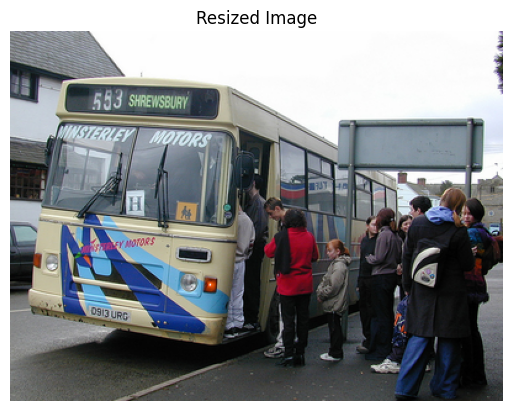

In [ ]:
# Save the resized image to local Colab drive
output_image_path = '/content/TranSalNet/example/reduced_COCO_val2014_000000005107.jpg'
image.save(output_image_path)
print(f"Resized image saved to {output_image_path}")

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Resized Image')
plt.show()

encode image

In [ ]:
with open(output_image_path, 'rb') as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
# Create payload
payload = json.dumps({'image': encoded_image})

In [ ]:
print(payload)

{"image": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEsAZADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCXzC5AHz47ABx+uGFOMgfO4kgdVzux77W5/I/yqI4LH5S646MBIPzHNIhEpAzuAPADeZj8DzVklnKmRPLHzDkKec/QHkfgal8/fuVt27PB5yP5N/OogyK4jCjb02en/AW/oaez/LsIUjPKnt/wFuR+BpiHpMEZw

###Lets set up the functions

**preprocess_img**

In [ ]:
def preprocess_img(image, channels=3):
    # Convert the PIL Image to a NumPy array
    img = np.array(image)

    # Ensure the image is in the correct channel format
    if channels == 1:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif channels == 3 and len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    shape_r = 288
    shape_c = 384
    img_padded = np.ones((shape_r, shape_c, channels), dtype=np.uint8)
    if channels == 1:
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)
    original_shape = img.shape
    rows_rate = original_shape[0] / shape_r
    cols_rate = original_shape[1] / shape_c
    if rows_rate > cols_rate:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        img = cv2.resize(img, (new_cols, shape_r))
        if new_cols > shape_c:
            new_cols = shape_c
        img_padded[:,
        ((img_padded.shape[1] - new_cols) // 2):((img_padded.shape[1] - new_cols) // 2 + new_cols)] = img
    else:
        new_rows = (original_shape[0] * shape_c) // original_shape[1]
        img = cv2.resize(img, (shape_c, new_rows))

        if new_rows > shape_r:
            new_rows = shape_r
        img_padded[((img_padded.shape[0] - new_rows) // 2):((img_padded.shape[0] - new_rows) // 2 + new_rows),
        :] = img

    return img_padded

**model load (modified to work locally)**

In [ ]:
# Set up logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
#def model_fn(model_dir)
def model_fn(model_path):
    #model_path = os.path.join(model_dir, 'Transalnet_best_model.onnx')
    #model_path = os.path.join(model_path)
    model = ort.InferenceSession(model_path)
    logging.info(f"Model loaded from {model_path}")
    logging.info(f"Numpy version: {np.__version__}")
    logging.info(f"ONNX Runtime version: {ort.__version__}")
    return model




**input_fn (modified to work locally)**

In [ ]:
def input_fn(request_body, request_content_type='application/json'):
    logging.debug(f"Request content type: {request_content_type}")
    logging.debug(f"Request body: {request_body}")

    if request_content_type == 'application/json':
        data = json.loads(request_body)
        if 'image' in data:
            encoded_image = data['image']
            image_data = base64.b64decode(encoded_image)
            image = Image.open(io.BytesIO(image_data)).convert('RGB')
            img = preprocess_img(image)  # Padding and resizing input image into 384x288
            img = np.array(img)/255
            img = np.expand_dims(np.transpose(img, (2, 0, 1)), axis=0)
            img = img.astype(np.float32)
            logging.debug(f"Image decoded, size: {image.size}")
            return img
        else:
            raise ValueError("Missing 'image' key in JSON payload")
    else:
        raise ValueError(f"Unsupported content type: {request_content_type}")



In [ ]:
# Call input_fn with the payload
img_tensor = input_fn(payload)

print("Processed image tensor shape:", img_tensor.shape)


Processed image tensor shape: (1, 3, 288, 384)


**predict**

In [ ]:
def predict_fn(input_data, model):
    input_name = model.get_inputs()[0].name
    outputs = model.run(None, {input_name: input_data})
    return outputs[0]




make a prediction

In [ ]:
print(model_path)

/content/drive/My Drive/capstone2/Transalnet_best_model.onnx


In [ ]:
# Use the uploaded file path
#model_path = 'Transalnet_best_model.onnx'
# Update this to match the uploaded file name
model = model_fn(model_path)
pred_saliency = predict_fn(img_tensor, model)
print("Prediction completed successfully")

Prediction completed successfully


**output_fn (modified to test locally)**

In [ ]:
def output_fn(prediction, response_content_type='application/json'):
    if response_content_type == 'application/json':
        # Squeeze and convert to PIL Image
        pred_saliency_np = prediction.squeeze()
        toPIL = transforms.ToPILImage()
        pic = toPIL(pred_saliency_np)

        # Convert the PIL image back to base64-encoded string
        buffered = io.BytesIO()
        pic.save(buffered, format="PNG")
        encoded_image = base64.b64encode(buffered.getvalue()).decode('utf-8')

        response_body = json.dumps({'image': encoded_image})
        return response_body
    else:
        raise ValueError("Unsupported content type: {}".format(response_content_type))

generate output in json format

In [ ]:
response =  json.loads(output_fn(pred_saliency))

In [ ]:
print(response)

{'image': 'iVBORw0KGgoAAAANSUhEUgAAAYAAAAEgCAAAAACYsPuNAAAtYElEQVR4nO1d2YIbu6oFOef/P/gei/sgAQuEanB375zdNknsGlUSw2KQyqEHfegv0n/+dgfendrf7sC7E//tDnzoQx/60Ic+9KEPfehDH/rQhz70oQ996EMf+tCHPvShD33oQx/60Id+jn5sUjg0LD/1lH8/fbcATtv7yCLSdwrgalsfGQB9jwD4YM9JDnfflL5FALzZrki2O+9JXxYAV+1sWpVy+72l8FUBcGqlNIYaez4iIPqiAHj5nMeF5cwRSLn7fvQVAQDnVyGsuwsASTj8piJ4WQBMyPYag/bkvJe0/270qgAm10H9L8RCqxNOgnhDCbwkAOB+wJ4kicIJZ7wxtr+tDF4VABNxMgGmQiZO4HVB++eHvK0EXhAATzYzslwPJTE4uc7L/HCGix0G+bwJ3ReA677znc0okv6Pb+No4LhpvuhWwKI3obsCYLSAaQY8BBC8cpBDcriANjL+JnG8kwj+3LvcNZtV9VcDSEAUUX9qPJMQsTDJkIGRsBARv40E7lmAKb3r/tgb/xj4H/xA9LdD6R15SKSrDci7wdAtC8B0a3AfMYhBNjkUQgtw2HEmN8Ue1mvfxQbuWIArPghgfLHxH1zxNAKs+qjWTyEMQei2oGm8iw3csACQFU+tZ1b+75yBa7I5AGC+iJCMq7hr48JCLO9iAzchaGj20PvpAbgpGBkiJVfgJjAFYMwn4on6TK3z8M4mgbeg6wKwAGjCDjEb89ltYV7goSoRhfhnSmDSFAcRURNS1R/sfwshXBWABTWK+oP/vJDhEKMAMNtS6pP3PIMgJmIZdwgR03uYwQs+QLPfRo0bU5BDI3fHIzBSEuB/py4iPEUgRE2GB+DJcn6fUOiiACCqjP6XmBs3E0LTM5qleS5ssU6XJiwiXbjL5Dy1zjIEJkzv5AZuZ8LTDQ9uN6bB+aZf6hcmTjX1w

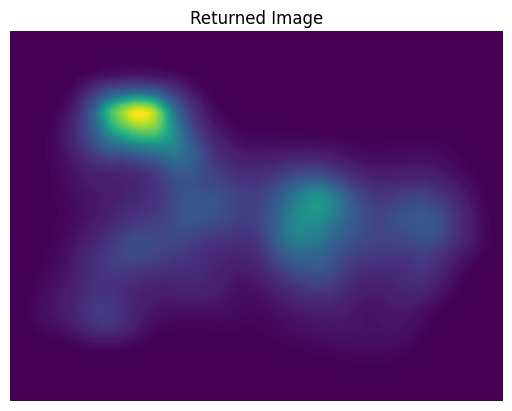

In [ ]:
 # Extract the base64-encoded image data
encoded_image = response['image']
# Decode the base64-encoded image data
image_data = base64.b64decode(encoded_image) # Convert the decoded data to an image
image = Image.open(io.BytesIO(image_data))

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Returned Image')
plt.show()


original image below

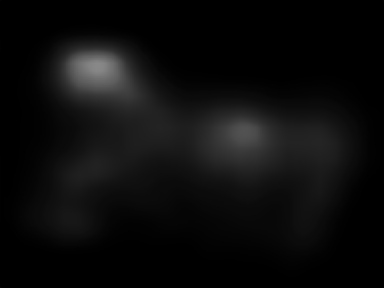

In [ ]:
# Final step
toPIL = transforms.ToPILImage()
pic = toPIL(pred_saliency_np)
pic.save('result.png')

# Display the result
from IPython.display import Image as IPyImage
IPyImage('result.png')

In [ ]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         0.34.2
aiohappyeyeballs                   2.4.3
aiohttp                            3.10.10
aiosignal                          1.3.1
alabaster                          0.7.16
albucore                           0.0.19
albumentations                     1.4.20
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.4
astropy-iers-data                  0.2024.11.4.0.33.34
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread        